<h1 style="font-size:3rem;color:orange;">Predicting Loan E-Signatures 🖆</h1>

<h2 style="font-size:2rem;color:orange;">Data Pre-processing and Model Building</h2>

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os
import pandas as pd

### Import Data

In [2]:
df_users_financial = pd.read_csv("../data/processed/new_P39-Financial-Data.csv")

### Data Peek 👀

In [3]:
df_users_financial.head()

,entry_id,age,monthly_income,years_employed,current_address_year,amount_requested,risk_score,inquiries_last_month,pay_schedule,home_owner,has_debt,personal_account_months,avg_risk_score,avg_ext_quality_score,e_signed
0,7629673,40,3135,3,3,550,36200,10,bi-weekly,1,1,30,0.661151,0.480918,1
1,3560428,61,3180,6,3,600,30150,9,weekly,0,1,86,0.789841,0.680720,0
2,6934997,23,1540,0,0,450,34550,7,weekly,0,1,19,0.691712,0.531712,0
3,5682812,40,5230,6,1,700,42150,8,bi-weekly,0,1,86,0.793179,0.692552,1
4,5335819,33,3590,5,2,1100,53850,12,semi-monthly,0,1,98,0.688483,0.744634,0


In [4]:
df_users_financial.describe()

,entry_id,age,monthly_income,years_employed,current_address_year,amount_requested,risk_score,inquiries_last_month,home_owner,has_debt,personal_account_months,avg_risk_score,avg_ext_quality_score,e_signed
count,1.790800e+04,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000
mean,5.596978e+06,43.015412,3657.214653,3.526860,3.584711,950.446449,61086.302211,6.457226,0.425173,0.795399,45.467389,0.717640,0.622590,0.538251
std,2.562473e+06,11.873107,1504.890063,2.259732,2.751937,698.543683,15394.255020,3.673093,0.494383,0.403421,23.258829,0.070536,0.115284,0.498549
min,1.111398e+06,18.000000,905.000000,0.000000,0.000000,350.000000,2100.000000,1.000000,0.000000,0.000000,0.000000,0.353661,0.022057,0.000000
25%,3.378999e+06,34.000000,2580.000000,2.000000,2.000000,600.000000,49350.000000,4.000000,0.000000,1.000000,29.000000,0.668689,0.547725,0.000000
50%,5.608376e+06,42.000000,3260.000000,3.000000,3.000000,700.000000,61200.000000,6.000000,0.000000,1.000000,40.000000,0.719793,0.627009,1.000000
75%,7.805624e+06,51.000000,4670.000000,5.000000,5.000000,1100.000000,72750.000000,8.000000,1.000000,1.000000,54.000000,0.769095,0.702689,1.000000
max,9.999874e+06,96.000000,9985.000000,16.000000,12.000000,10200.000000,99750.000000,30.000000,1.000000,1.000000,183.000000,0.925252,0.966953,1.000000


Here we generate an interactive [YData Profiling](https://docs.profiling.ydata.ai/4.6/) report of our processed data which we save to a HTML file 

In [5]:
%%capture
from ydata_profiling import ProfileReport

# The local directory to save the report
data_dir = '../data/processed'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Generate the report & save to a file
data_profile = ProfileReport(df_users_financial, title="Profiling Report of new_P39-Financial-Data.csv")
data_profile.to_file(f'../data/processed/ProfileReport_new_P39-Financial-Data.html')

- To view in the notebook, create a new cell below with ```data_profile.to_notebook_iframe()```

- View the report in the web browser [here](https://ml-fintech-case-studies.netlify.app/profile_reports/new_P39-Financial-Data.html#overview) 👁️‍🗨️

  <img src="../../images/p39_processed_profile-report.png" width="580" alt="ProfileReport"/>

In [6]:
# Restore matplotlib to inline mode after viewing for plots
%matplotlib inline

# Data Pre-processing <img src="../../images/processing.gif" width="40" alt="Processing"/>

### Remove the label from the features

In [7]:
label = df_users_financial['e_signed']
df_users_financial = df_users_financial.drop(columns='e_signed')

### Feature Selection

In [8]:
df_users_financial = df_users_financial.drop(columns='pay_schedule')

### Transformations

In [9]:
# Convert all columns to float except 'entry_id'
columns_to_convert = df_users_financial.columns.difference(['entry_id'])
df_users_financial[columns_to_convert] = df_users_financial[columns_to_convert].astype(float)

In [10]:
# Take the log of 'amount_requested' to address skew
df_users_financial['log_amount_requested'] = np.log(df_users_financial['amount_requested'])

# Drop the previous values 
df_users_financial.drop('amount_requested', axis=1, inplace=True)

### Split the dataset into training and test sets

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into an 80/20 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(df_users_financial, label, 
                                                    test_size=0.2, 
                                                    stratify=label, 
                                                    random_state=42)
print(X_train.shape)
print(X_test.shape)

(14326, 13)
(3582, 13)


### Filter model data

In [12]:
# Purge user identification, persist to associate the prediction to the user it came from 
user_identification = 'entry_id'

train_identifier = X_train[user_identification]
X_train = X_train.drop(columns = [user_identification])

test_identifier = X_test[user_identification]
X_test = X_test.drop(columns = [user_identification])

### Feature Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

def standard_scale(train_df, val_df, test_df, columns_to_exclude):
    """
    Performs standard scaling on numerical columns within DataFrames.
    Accepts training, validation, and test DataFrames, and an array of column names to exclude.
    Returns the modified DataFrames.
    """
    # Identify columns to be excluded from scaling
    excluded_columns = [col for col in train_df.columns if any(substring in col for substring in columns_to_exclude)]
    # Columns to be standardized
    columns_to_scale = [col for col in train_df.columns if col not in excluded_columns]
    # Instantiate the scaler
    standard_scaler_X = StandardScaler()
    # Fit on and transform the selected columns in the training data
    train_df[columns_to_scale] = standard_scaler_X.fit_transform(train_df[columns_to_scale])
    # Transform selected columns in the validation data using the same scaler
    val_df[columns_to_scale] = standard_scaler_X.transform(val_df[columns_to_scale])
    # Transform selected columns in test data using the same scaler
    test_df[columns_to_scale] = standard_scaler_X.transform(test_df[columns_to_scale])
    
    return train_df, val_df, test_df

# Model Building 🤖

### Training Data

In [14]:
# Split the training set into a 80/20 training/validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                test_size=0.2, 
                                                                stratify=y_train, 
                                                                random_state=42)
print(X_train.shape)
print(X_validation.shape)

(11460, 12)
(2866, 12)


In [15]:
# Scale the datasets
columns_to_exclude = [' ']
X_train, X_validation, X_test = standard_scale(X_train, X_validation, X_test, columns_to_exclude)

### Training Data Combined

For cross-validation and final model training

In [16]:
# Concatenate the training and validation feature datasets vertically
X_train_and_validation = pd.concat([X_train, X_validation], axis=0).reset_index(drop=True)

# Concatenate the training and validation label datasets vertically
y_train_and_validation = pd.concat([y_train, y_validation], axis=0).reset_index(drop=True)

### Metrics Function

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def evaluate_scores_and_concat(prob_posclass, y_test, y_predict, model_name, results_dataframe): 
    """
    Evaluates model scores and concatenates results to a DataFrame.
    """
    # Get scores
    accuracy = accuracy_score(y_test, y_predict)   # CorrectPredicts/TotalPredicts  
    precision = precision_score(y_test, y_predict) # TP/(TP+FP)
    recall = recall_score(y_test, y_predict)       # TP/(TP+FN)
    f1 = f1_score(y_test, y_predict)               # 2*(precision*recall)/(precision+recall)
    roc_auc = roc_auc_score(y_test, prob_posclass)
    # Transfer scores to a DataFrame
    new_results = pd.DataFrame([[model_name, accuracy, precision, recall, f1, roc_auc]],
                       columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])
    # Concatenate results to the results_dataframe vertically
    results_dataframe = pd.concat([results_dataframe, new_results], axis=0).reset_index(drop=True)
    
    return results_dataframe

## Logistic Regression 📈

### Training

In [18]:
from sklearn.linear_model import LogisticRegression

# Penalty 'l1' Lasso regularization
lr_model = LogisticRegression(penalty='l1', solver='saga', random_state=42)

lr_model.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='saga')

### Evaluation

In [19]:
# Initialize a results DataFrame
df_results = pd.DataFrame()

In [20]:
from sklearn.model_selection import cross_val_score

# Make predictions from the validation set
y_predict = lr_model.predict(X_validation)

# Predict the probabilities of the positive class
prob_posclass = lr_model.predict_proba(X_validation)[:, 1]

# Get model scores
df_results = evaluate_scores_and_concat(prob_posclass, y_validation, y_predict, 'LogisticRegression (Lasso)', df_results)

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=lr_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 57.08%
Confidence Interval: +- 1.77%



,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression (Lasso),0.572226,0.582681,0.723914,0.645665,0.594455


## Support Vector Machines 🛤️

### SVC (Linear) Training

In [21]:
from sklearn.svm import SVC

# Linear kernel
svc_linear_model = SVC(kernel='linear', probability=True, random_state=42)

svc_linear_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

### SVC (Linear) Evaluation

In [22]:
# Make predictions from the validation set
y_predict = svc_linear_model.predict(X_validation)

# Predict the probabilities of the positive class
prob_posclass = svc_linear_model.predict_proba(X_validation)[:, 1]

# Get model scores
df_results = evaluate_scores_and_concat(prob_posclass, y_validation, y_predict, 'SVC (Linear)', df_results)

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=svc_linear_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 57.65%
Confidence Interval: +- 1.41%



,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression (Lasso),0.572226,0.582681,0.723914,0.645665,0.594455
1,SVC (Linear),0.575017,0.582195,0.745949,0.653977,0.593614


### SVC (RBF) Training

In [23]:
from sklearn.svm import SVC

# Radial Basis Function kernel (default)
svc_rbf_model = SVC(kernel='rbf', probability=True, random_state=42)

svc_rbf_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

### SVC (RBF) Evaluation

In [24]:
# Make predictions from the validation set
y_predict = svc_rbf_model.predict(X_validation)

# Predict the probabilities of the positive class
prob_posclass = svc_rbf_model.predict_proba(X_validation)[:, 1]

# Get model scores
df_results = evaluate_scores_and_concat(prob_posclass, y_validation, y_predict, 'SVC (RBF)', df_results)

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=svc_rbf_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 61.13%
Confidence Interval: +- 1.50%



,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression (Lasso),0.572226,0.582681,0.723914,0.645665,0.594455
1,SVC (Linear),0.575017,0.582195,0.745949,0.653977,0.593614
2,SVC (RBF),0.601884,0.610197,0.721322,0.661123,0.638092


## Random Forest Classifier 🌳

### Training

In [25]:
from sklearn.ensemble import RandomForestClassifier

# 100 Trees
rf_model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)

rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

### Evaluation

In [26]:
# Make predictions from the validation set
y_predict = rf_model.predict(X_validation)

# Predict the probabilities of the positive class
prob_posclass = rf_model.predict_proba(X_validation)[:, 1]

# Get model scores
df_results = evaluate_scores_and_concat(prob_posclass, y_validation, y_predict, 'RandomForestClassifier (n=100)', df_results)

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=rf_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 63.15%
Confidence Interval: +- 2.77%



,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression (Lasso),0.572226,0.582681,0.723914,0.645665,0.594455
1,SVC (Linear),0.575017,0.582195,0.745949,0.653977,0.593614
2,SVC (RBF),0.601884,0.610197,0.721322,0.661123,0.638092
3,RandomForestClassifier (n=100),0.621424,0.641708,0.672067,0.656537,0.681449


## XGBoost Classifier 🚀 

### Training

In [27]:
from xgboost import XGBClassifier

# 100 Stages
xgb_model = XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

### Evaluation

In [28]:
# Make predictions from the validation set
y_predict = xgb_model.predict(X_validation)

# Predict the probabilities of the positive class
prob_posclass = xgb_model.predict_proba(X_validation)[:, 1]

# Get model scores
df_results = evaluate_scores_and_concat(prob_posclass, y_validation, y_predict, 'XGBClassifier (n=100)', df_results)

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=xgb_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 63.10%
Confidence Interval: +- 2.09%



,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression (Lasso),0.572226,0.582681,0.723914,0.645665,0.594455
1,SVC (Linear),0.575017,0.582195,0.745949,0.653977,0.593614
2,SVC (RBF),0.601884,0.610197,0.721322,0.661123,0.638092
3,RandomForestClassifier (n=100),0.621424,0.641708,0.672067,0.656537,0.681449
4,XGBClassifier (n=100),0.625960,0.648020,0.668179,0.657945,0.678069


## Gradient Boosting Classifier 🚀 

### Training

In [29]:
from sklearn.ensemble import GradientBoostingClassifier 

# 100 Stages
gbc_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### Evaluation

In [30]:
# Make predictions from the validation set
y_predict = gbc_model.predict(X_validation)

# Predict the probabilities of the positive class
prob_posclass = gbc_model.predict_proba(X_validation)[:, 1]

# Get model scores
df_results = evaluate_scores_and_concat(prob_posclass, y_validation, y_predict, 'GradientBoostingClassifier (n=100)', df_results)

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=gbc_model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
df_results

Cross Validated Accuracy: 63.72%
Confidence Interval: +- 1.57%



,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression (Lasso),0.572226,0.582681,0.723914,0.645665,0.594455
1,SVC (Linear),0.575017,0.582195,0.745949,0.653977,0.593614
2,SVC (RBF),0.601884,0.610197,0.721322,0.661123,0.638092
3,RandomForestClassifier (n=100),0.621424,0.641708,0.672067,0.656537,0.681449
4,XGBClassifier (n=100),0.625960,0.648020,0.668179,0.657945,0.678069
5,GradientBoostingClassifier (n=100),0.629100,0.641677,0.704472,0.671610,0.686574


## Save Data 💾

In [31]:
# Create a directory to save results
directory = "../experiments/baseline_metrics"
if not os.path.exists(directory): os.makedirs(directory)

df_results.to_csv(f"{directory}/baseline_metrics_002.csv", index=False)

## Baseline Model Evaluation <img src="../../images/charts.gif" width="43" alt="Chart Bars"/>

Above we discover the [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) algorithm has provided some of our best scores thus far and proceed with a further evaluation of the model

In [32]:
# Define model
model = gbc_model

### Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def sklearn_confusion_matrix(y_test, y_predict, model):
    """
    Generates a scikit-learn confusion matrix. 
    Accepts the test labels, the predicted labels, and the trained model.
    Displays the plot.
    """
    # Create a confusion matrix with the labels and our model's predictions
    conf_matrix = confusion_matrix(y_test, y_predict)
    # Create the plot
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
    ax.set(title='Confusion Matrix for Predicting Loan E-Signature Model')
    display.plot(ax=ax, cmap='Blues', values_format='d')
    plt.show()

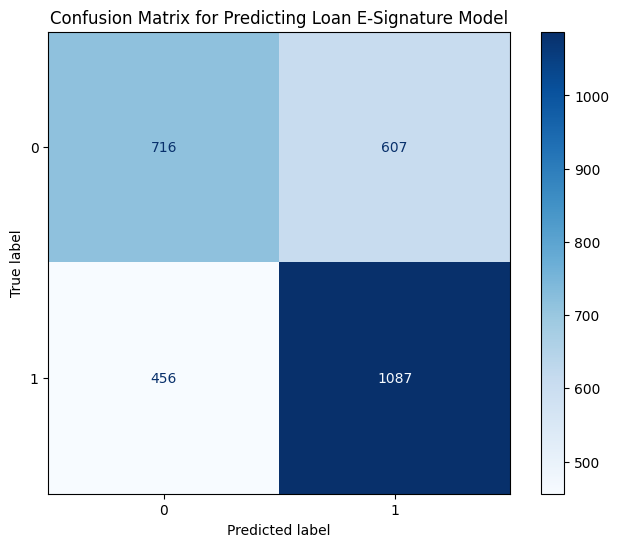

              precision    recall  f1-score   support

           0      0.611     0.541     0.574      1323
           1      0.642     0.704     0.672      1543

    accuracy                          0.629      2866
   macro avg      0.626     0.623     0.623      2866
weighted avg      0.627     0.629     0.627      2866



In [34]:
from sklearn.metrics import classification_report

# Make predictions
y_predict = model.predict(X_validation)

# Plot confusion matrix & display classification report
sklearn_confusion_matrix(y_validation, y_predict, model)
print(classification_report(y_validation, y_predict, digits=3))

### Receiver Operating Characteristic (ROC) Curve

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn.objects as so

def plot_roc_curve(X_test, y_test, model):
   """
   Function for plotting the ROC Curve.
   Accepts the test features, test labels, and the trained model.
   Displays the plot and returns the AUC score. 
   """
   # Generate data for a 45 degree line
   noskill_probabilities = [0 for number in range(len(y_test))]
   # Predict the probabilities of the positive class
   probabilities_posclass = model.predict_proba(X_test)[:, 1]
   # Calculate data for horizontal line
   falsepositive_rate_noskill, truepositive_rate_noskill, _ = roc_curve(y_test, noskill_probabilities)
   # Calculate data for ROC curve
   falsepositive_rate, truepositive_rate, _ = roc_curve(y_test, probabilities_posclass)
   # Calculate AUC
   roc_auc = roc_auc_score(y_test, probabilities_posclass)
   # Display AUC
   print("AUC (Area Under the ROC Curve): {:.2f}".format(roc_auc))
   # Plot with Seaborn Objects
   plt = (so.Plot()
      .add(so.Line(color='red'), x =falsepositive_rate, y=truepositive_rate)
      .add(so.Line(color='blue', linestyle='dashed'), x=falsepositive_rate_noskill, y=truepositive_rate_noskill)
      .layout(size = (8,5))
      )
   plt.show()
   
   return roc_auc

AUC (Area Under the ROC Curve): 0.69


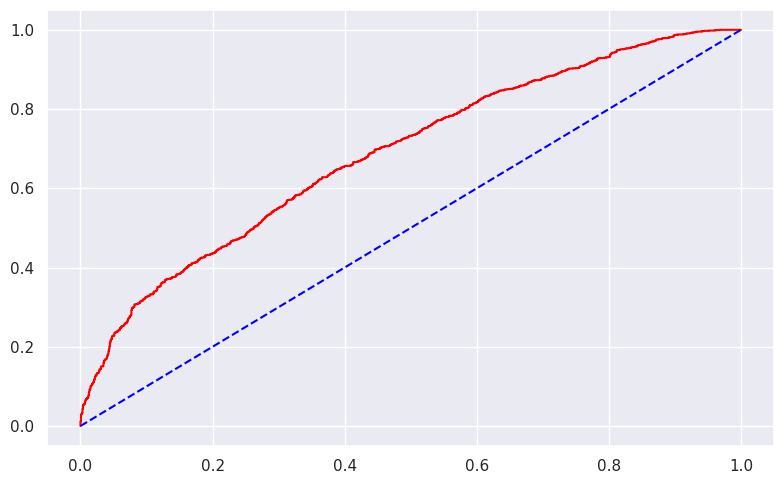

In [36]:
roc_auc = plot_roc_curve(X_validation, y_validation, model)

We observe the model's discriminatory power is slightly less than acceptable and aim to improve this score via hyperparameter optimization

### Feature Importances

In [37]:
def plot_feature_importance(X_train, model):
    """
    Plots feature importances from a model.
    Accepts the training features DataFrame and the trained model.
    Displays the plot and returns a DataFrame of features and their importance scores.
    """
    # Extract feature names from the DataFrame
    features = X_train.columns.tolist()
    # Create a DataFrame with feature names and their importance
    feature_df = pd.DataFrame({
      'Feature': features,
      'Importance': model.feature_importances_
      })
    # Sort the DataFrame by importance in descending order
    feature_df = feature_df.sort_values(by='Importance', ascending=False)
    # Adjust figure size as needed
    plt.figure(figsize=(8, 6)) 
    plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis() # Place highest importance at top
    plt.show()

    return feature_df

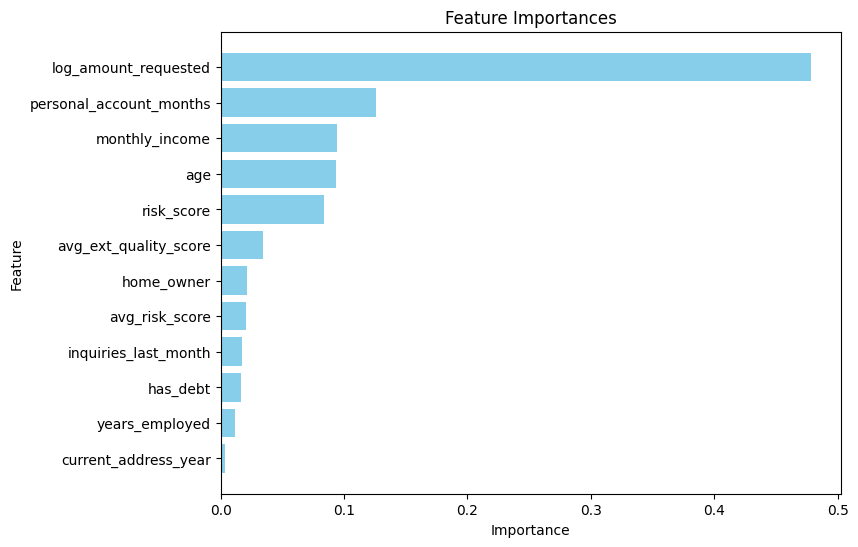

,Feature,Importance
11,log_amount_requested,0.478660
8,personal_account_months,0.126183
1,monthly_income,0.093869
0,age,0.093378
4,risk_score,0.083966
10,avg_ext_quality_score,0.033968
6,home_owner,0.021493
9,avg_risk_score,0.020478
5,inquiries_last_month,0.017204
7,has_debt,0.016039


In [38]:
feature_df = plot_feature_importance(X_train, model)
feature_df

## Model Tuning <img src="../../images/tuning.gif" width="50" alt="Tuning"/>

Here we utilize Hyperopt for model tuning to take advantage of Bayesian Optimization

- We begin by initializing MLflow to track our [experiment](../experiments/README.md) 🧪 

In [39]:
# Define a location to save experiments
experiment_dir = "../experiments/mlflow_demo"
if not os.path.exists(experiment_dir): os.makedirs(experiment_dir)

In [40]:
import random

# 5 digit random number for the experiment
random_number = random.randint(10_000, 99_999)
# Set the tracking server URI
mlflow.set_tracking_uri(f'file://{os.path.abspath(experiment_dir)}')
# Create a new experiment
EXPERIMENT_ID = mlflow.create_experiment(f'hyperopt_tuning_{random_number}')
# Fetch experiment details
experiment = mlflow.get_experiment(EXPERIMENT_ID)

print(f"Name: {experiment.name}")
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: file://{experiment_dir}/{experiment.experiment_id}")
print(f"Tags: {experiment.tags}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")
print(f"Creation timestamp: {experiment.creation_time}")

Name: hyperopt_tuning_50126
Experiment_id: 288383587775009577
Artifact Location: file://../experiments/mlflow_demo/288383587775009577
Tags: {}
Lifecycle_stage: active
Creation timestamp: 1699730617748



- Define the objective function

In [41]:
from hyperopt import STATUS_OK
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from mlflow.models.signature import infer_signature

def objective_function(space):
    """
    The objective function for Hyperopt. 
    Accepts the hyperparameter search space & returns a loss score to minimize. 
    Logs metadata & the model from trials.
    """
    # Convert floats to integers for the model as needed
    space['n_estimators'] = int(space['n_estimators'])
    space['max_depth'] = int(space['max_depth'])
    space['min_samples_split'] = int(space['min_samples_split'])
    space['min_samples_leaf'] = int(space['min_samples_leaf'])
    
    # Define model
    model = GradientBoostingClassifier(**space, random_state=42)
    # Define cross-validation (if opted)
    auc_scores = cross_val_score(model, X_train_and_validation, y_train_and_validation, cv=3, scoring='roc_auc')
    # Cross validation mean & loss variance from scores
    roc_auc = np.mean(auc_scores)
    loss_variance = np.var(auc_scores, ddof=1)
    # Train the model & predict values for the validation set
    model.fit(X_train, y_train)
    y_val_predict = model.predict(X_validation)
    prob_posclass = model.predict_proba(X_validation)[:, 1]
    # Evaluation metrics
    val_accuracy = accuracy_score(y_validation, y_val_predict)
    val_precision = precision_score(y_validation, y_val_predict)
    val_recall = recall_score(y_validation, y_val_predict)
    val_f1 = f1_score(y_validation, y_val_predict)
    val_roc_auc = roc_auc_score(y_validation, prob_posclass)
    
    validation_metrics = {
      'accuracy': val_accuracy, 
      'precision': val_precision, 
      'recall': val_recall, 
      'F1': val_f1, 
      'roc_auc': val_roc_auc
    }
    
    with mlflow.start_run(experiment_id=experiment.experiment_id):
        mlflow.log_params(space)
        mlflow.log_params({"validation_feature_importances": model.feature_importances_})
        for name, metric in validation_metrics.items():
            mlflow.log_metric(f'validation_{name}', metric)
        mlflow.log_metric("cross_roc_auc", roc_auc)
        mlflow.log_metric("loss_variance", loss_variance)
        signature = infer_signature(X_train, y_val_predict)
        mlflow.sklearn.log_model(model, "model", 
                                 signature=signature, 
                                 input_example=X_train.iloc[[0]],
                                 pip_requirements="./requirements.txt")
        mlflow.sklearn.log_model(model, "model", pip_requirements="requirements.txt")
        mlflow.set_tag("estimator_name", model.__class__.__name__)
        mlflow.set_tag("estimator_class", model.__class__)
        mlflow.end_run()
    
    # Here we aim to maximize roc_auc, thus return it as a negative value
    return {'loss': -roc_auc, 'loss_variance': loss_variance, 'status': STATUS_OK}

- Define the search space

In [42]:
from hyperopt import hp

search_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 400, 10),
    'max_depth': hp.quniform('max_depth', 5, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'max_features': None
    }

- Run Hyperopt. _For optimal (or fastest) results, see [suggested formulas](https://www.databricks.com/blog/2021/04/15/how-not-to-tune-your-model-with-hyperopt.html). This may take some time, go have some tea_ 

In [43]:
from hyperopt import fmin, tpe, Trials

# Demo number of trials, adjust for utilization
num_evals = 5
trials = Trials()

best_hyperparams = fmin(fn=objective_function, 
                        space=search_space, 
                        algo=tpe.suggest, # Bayesian search w/ Tree Parzen Estimator (TPE)
                        max_evals=num_evals, 
                        trials=trials, 
                        rstate=np.random.default_rng(42)
                       ) 

print(best_hyperparams)

100%|██████████| 5/5 [02:33<00:00, 30.71s/trial, best loss: -0.7007203349442966]
{'learning_rate': 0.014062170424443061, 'max_depth': 9.0, 'min_samples_leaf': 7.0, 'min_samples_split': 9.0, 'n_estimators': 290.0, 'subsample': 0.9440966222920864}


#### MLflow Functions

In [44]:
def get_best_scoring_model(metric_name, ascending_boolean, experiment_dir, experiment_ID):
    """
    Returns a model with the best scoring metric from MLflow.
    Accepts the metric name, an ascending order boolean (False=Higher Scores, True=Lower Scores),
    path to the directory hosting the experiment, and the experiment_id.
    Returns the model with the best scoring metric from MLflow. 
    """
    # Set the tracking server URI, configured here for file storage
    mlflow.set_tracking_uri(f'file://{os.path.abspath(experiment_dir)}')
    # Get the experiment ID
    experiment_id = experiment_ID
    # Get runs from the experiment
    runs = mlflow.search_runs(experiment_ids=[experiment_id], filter_string='', max_results=1000)
    # Filter the runs for best desired metric
    best_run = runs.sort_values(f"metrics.{metric_name}", ascending=ascending_boolean).iloc[0]
    # Provide the model URI
    best_model_uri = best_run["artifact_uri"] + "/model"
    # Modify this line to your flavor of model: sklearn, spark, xgboost, pytorch, tensorflow, etc.
    model = mlflow.sklearn.load_model(best_model_uri)
    
    print("Best Scoring Run ID:", best_run.run_id)
    print("Model Type:", type(model).__name__)
    print("Hyperparameters: ", model.get_params())
    
    return model

In [45]:
def get_model(experiment_dir,run_id):
    """
    Returns a model logged with MLflow.
    Accepts a path to the directory hosting the experiment and run_id.
    """
    # Set the tracking server URI, here configured for file storage
    mlflow.set_tracking_uri(f'file://{os.path.abspath(experiment_dir)}')
    # Specify model URI
    model_uri = f"runs:/{run_id}/model" 
    # Modify this line to your flavor of model: sklearn, spark, xgboost, pytorch, tensorflow, etc.
    model = mlflow.sklearn.load_model(model_uri)
    
    return model

### K-Fold Cross Validation

Evaluate the tuned model across a more thorough cross-validation process

In [46]:
# Active experiment_ID => experiment.experiment_id
experiment_ID = "455990813687122612"
# Active experiment_dir => experiment_dir
experiment_dir = "../experiments/mlflow_gbc"

# Load the best scoring model from the experiment 
model = get_best_scoring_model("cross_roc_auc", False, experiment_dir, experiment_ID)

Best Scoring Run ID: 1be79e9f05e24d009bab26abe40aab8e
Model Type: GradientBoostingClassifier
Hyperparameters:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.015275982184203713, 'loss': 'log_loss', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 320, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.9015413148869229, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [47]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator=model, X=X_train_and_validation, y=y_train_and_validation, cv=10)

print("Cross Validated Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Confidence Interval: +- {:.2f}%\n".format((accuracies.std()*2)*100))
print(accuracies)

Cross Validated Accuracy: 64.48%
Confidence Interval: +- 2.03%

[0.64410328 0.64619679 0.65247732 0.65875785 0.64759246 0.66015352
 0.62988827 0.63058659 0.64315642 0.63477654]


## Final Model Training 🦾

Load the model from MLflow 

In [48]:
# Directory hosting the experiment and run_id
experiment_dir = "../experiments/mlflow_gbc"
run_id = "1be79e9f05e24d009bab26abe40aab8e"

model = get_model(experiment_dir, run_id)

Train the model

In [49]:
# Train model on the train & validation data
model.fit(X_train_and_validation, y_train_and_validation)

GradientBoostingClassifier(learning_rate=0.015275982184203713, max_depth=7,
                           min_samples_leaf=4, min_samples_split=7,
                           n_estimators=320, random_state=42,
                           subsample=0.9015413148869229)

## Final Model Evaluation <img src="../../images/charts.gif" width="43" alt="Chart Bars"/>

In [50]:
# DataFrame for storing metrics
df_final_metrics = pd.DataFrame()

In [51]:
# Make predictions from the test set
y_predict = model.predict(X_test)

# Predict probabilities of the positive class
prob_posclass = model.predict_proba(X_test)[:, 1]

# Model info
model_type = type(model).__name__
run_id = str(run_id) if run_id else "(tuned)"

# Get model scores
df_final_metrics = evaluate_scores_and_concat(prob_posclass, y_test, y_predict, f"{model_type} {run_id[:6]}...", df_final_metrics)
df_final_metrics

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,GradientBoostingClassifier 1be79e...,0.646008,0.658501,0.7111,0.683791,0.711921


### Confusion Matrix

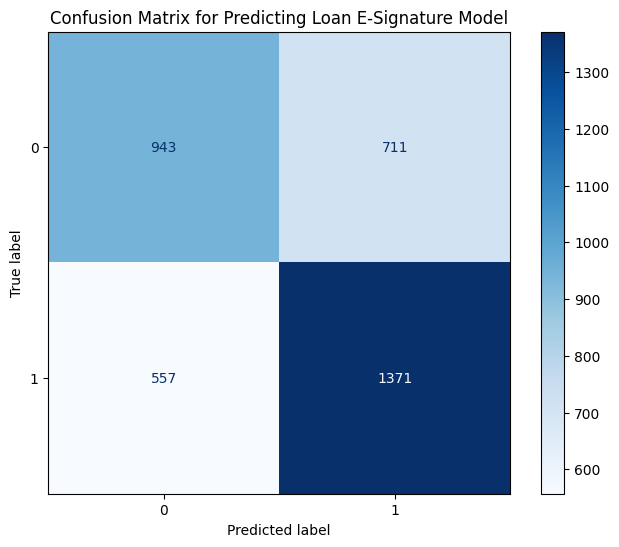

              precision    recall  f1-score   support

           0      0.629     0.570     0.598      1654
           1      0.659     0.711     0.684      1928

    accuracy                          0.646      3582
   macro avg      0.644     0.641     0.641      3582
weighted avg      0.645     0.646     0.644      3582



In [52]:
# Plot confusion matrix & display classification report
sklearn_confusion_matrix(y_test, y_predict, model)
print(classification_report(y_test, y_predict, digits=3))

### Receiver Operating Characteristic (ROC) Curve

AUC (Area Under the ROC Curve): 0.71


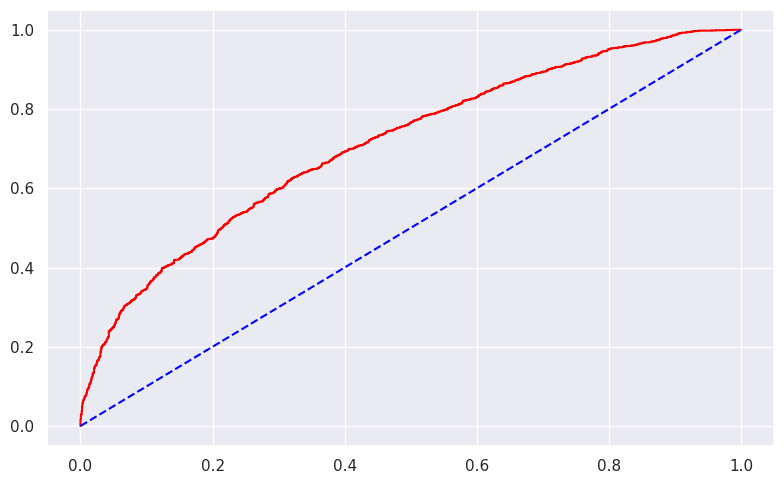

In [53]:
roc_auc = plot_roc_curve(X_test, y_test, model)

We note the model's discriminatory power has improved and is considered reasonable

### Feature Importances

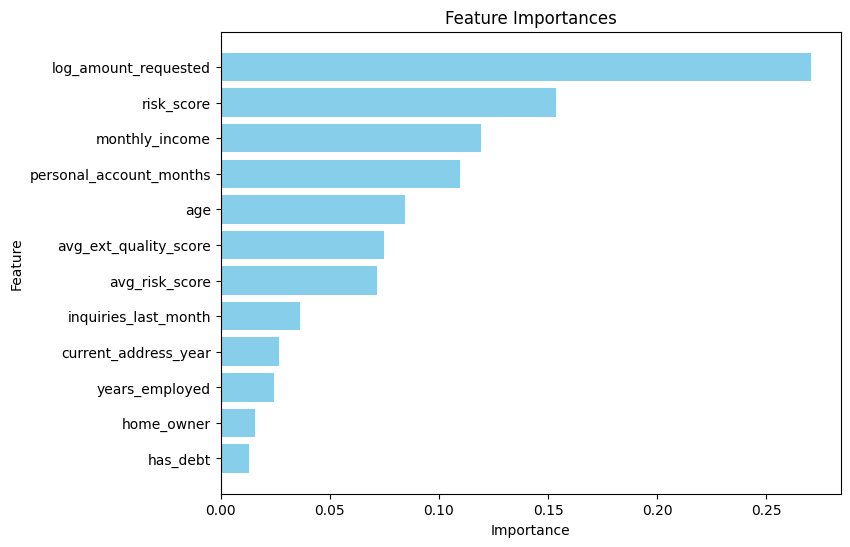

,Feature,Importance
11,log_amount_requested,0.270621
4,risk_score,0.153732
1,monthly_income,0.119086
8,personal_account_months,0.109500
0,age,0.084253
10,avg_ext_quality_score,0.074969
9,avg_risk_score,0.071650
5,inquiries_last_month,0.036515
3,current_address_year,0.026788
2,years_employed,0.024235


In [54]:
feature_df = plot_feature_importance(X_train_and_validation, model)
feature_df

## Save Model 💾

Next we save the optimized model along with associated metrics, metadata, and artifacts

In [55]:
# Create a directory to save sample training data 
sample_dir = "../data/samples"
if not os.path.exists(sample_dir): os.makedirs(sample_dir)
    
type_of_model = type(model).__name__
    
# Create a directory to save the model
model_dir = f"../models/{type_of_model}"
if not os.path.exists(model_dir): os.makedirs(model_dir)

In [56]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import random

random_number = random.randint(10_000, 99_999)

# Use directory above to set the tracking server URI
mlflow.set_tracking_uri(f'file://{os.path.abspath(model_dir)}')

# Set the experiment
experiment_name = "final_models"
experiment = mlflow.set_experiment(experiment_name)

# Save a sample of the data the model was trained on
sample_data = X_train.head()
sample_data.to_csv(f"{sample_dir}/sample_train_data_{random_number}.csv", index=False)

# Get model hyperpameters
model_params = model.get_params()
params_dict = dict(model_params)

# Predict the probabilities of the positive class
prob_posclass = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, prob_posclass)

with mlflow.start_run(experiment_id=experiment.experiment_id):
    mlflow.log_params(params_dict)
    mlflow.log_params({"test_feature_importances": model.feature_importances_})
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_predict))
    mlflow.log_metric("test_precision", precision_score(y_test, y_predict))
    mlflow.log_metric("test_recall", recall_score(y_test, y_predict))
    mlflow.log_metric("test_F1", f1_score(y_test, y_predict))
    mlflow.log_metric("test_roc_auc", roc_auc)
    mlflow.log_artifact(f"{sample_dir}/sample_train_data_{random_number}.csv")
    mlflow.sklearn.log_model(model, "model", pip_requirements="requirements.txt")
    mlflow.set_tag("estimator_name", model.__class__.__name__)
    mlflow.set_tag("estimator_class", model.__class__)
    mlflow.end_run()

- _To use the saved model for inference_ 🗨️

In [57]:
# Define directory hosting the experiment with your saved model and run_id
experiment_dir = "../models/GradientBoostingClassifier"
run_id = "4f7c99a6d0434a8f8fb312c2753304bf"

# Load the model
model = get_model(experiment_dir, run_id)

# Make predictions
y_predict = model.predict(X_test)

## Process Results 🔄

Here we format the final results from our model's predictions to the user this data came from. While we will not have 'e-signed' data for the deployed model's predictions in the future, a similar process can be applied. This enables the company to identify leads predicted not to complete the e-signature phase of the loan application process and experiment with different methods of onboarding them.

In [58]:
# Concatenate test labels to the user they came from
final_results_df = pd.concat([y_test, test_identifier], axis=1).dropna()

# Add predicted results from the model
final_results_df['predicted_results'] = y_predict
final_results_df = final_results_df[['entry_id', 'e_signed', 'predicted_results']].reset_index(drop=True)
 
final_results_df.head(10)

,entry_id,e_signed,predicted_results
0,6495937,0,1
1,2299475,1,1
2,4822403,0,1
3,7060498,1,1
4,2699789,0,0
5,4311351,1,1
6,3054334,0,0
7,5634938,1,1
8,7573188,1,0
9,7047275,1,0


### Save Data 💾

Persist final results and a list of applicants estimated to be unlikely to complete the loan onboarding process

In [59]:
from datetime import datetime
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table
import csv

# Define a directory to save results 
directory = "../data/results"
if not os.path.exists(directory): os.makedirs(directory)

# Process a timestamp
datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Save final results to a .csv file 
final_results_df.to_csv(f"../data/results/final_results_{datetime}.csv")

# Filter results for users unlikely to eSign
final_results_df = final_results_df[final_results_df.predicted_results == 0].copy()
unlikely_to_esign_df = final_results_df.copy().drop(columns = ['e_signed', 'predicted_results'])
# Save the filtered DataFrame to a .csv file
unlikely_to_esign_df.to_csv(f"../data/results/users_unlikely_to_eSign_{datetime}.csv")
# Define paths for conversion
csv_file = f"../data/results/users_unlikely_to_eSign_{datetime}.csv"
pdf_file = f"../data/results/users_unlikely_to_eSign_{datetime}.pdf"

# Convert the .csv file 
data = []
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    for row in reader: data.append(row)

# Create a PDF document
doc = SimpleDocTemplate(pdf_file, pagesize=letter)
# Create a table from the CSV data
table = Table(data)
# Add the table to the document
doc.build([table])